In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from multiprocessing.dummy import Pool as ThreadPool 
import itertools 

# for scikit-learn >= 0.18
from sklearn.model_selection import train_test_split

# for scikit-learn version <= 0.17
# from sklearn.cross_validation import train_test_split

%matplotlib inline

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 100
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

spatial_size=(32, 32)
hist_bins=32
#hist_range=(0, 256)
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

### Loading vehicles and non-vehicles images

Number of car images found :  8792
Number of non-car images found :  8968


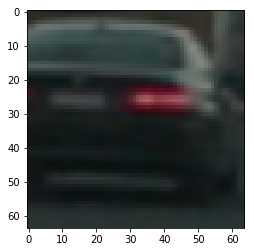

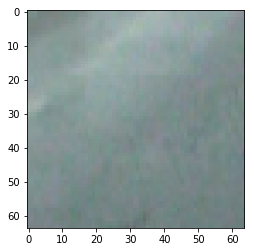

In [2]:
## Load images of vehicle and non-vehicle images

cars = glob.glob('C:/Temp/obj/vehicles/**/*.png')
notcars = glob.glob('C:/Temp/obj/non-vehicles/**/*.png')
random.shuffle(cars)
random.shuffle(notcars)


print ('Number of car images found : ', len(cars))
print ('Number of non-car images found : ', len(notcars))

plt.figure()
plt.imshow(mpimg.imread(cars[0]))
plt.figure()
plt.imshow(mpimg.imread(notcars[0]))

#print (cars[0:5])
#print(notcars[0:5])

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img):
    global spatial_size

    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, spatial_size).ravel() 
    #plt.figure()
    #plt.plot(features)
    
    # Return the feature vector
    return features

# Define a function to compute color histogram features
def color_hist(img):
    global hist_bins
    #global hist_range
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=hist_bins)#, range=hist_range)
    channel2_hist = np.histogram(img[:,:,1], bins=hist_bins)#, range=hist_range)
    channel3_hist = np.histogram(img[:,:,2], bins=hist_bins)#, range=hist_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, vis=False, feature_vec=True):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, block_norm= 'L1',
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, block_norm= 'L1',
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        #print("img", np.ptp(image,  axis=0))
        
        #print(file)
        # apply color conversion if other than 'RGB'
        if colorspace != 'RGB':
            if colorspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif colorspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif colorspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif colorspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif colorspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        # Apply bin_spatial() to get spatial color features
        #print("fet", np.ptp(feature_image,  axis=0))
        image_features.append(bin_spatial(feature_image))
        
        # Apply color_hist() also with a color space option now
        image_features.append(color_hist(feature_image))
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        image_features.append(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(image_features))
        
    # Return list of feature vectors
    return features

C:\I\IDEs\toolchains\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


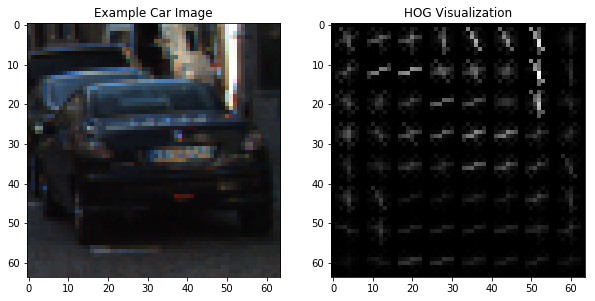

In [4]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

example_image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(example_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(example_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [5]:
# True = retrain and save, False = load from pickle
if(False):
    print("Extracting HOG features...")
    t=time.time()
    car_features = extract_features(cars)
    notcar_features = extract_features(notcars)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Plot some graphs to show normilisation
    car_ind = np.random.randint(0, len(cars))
    scaled_X = X_scaler.transform(X)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    #Save to pickle
    print("Saving pickle")
    dist_pickle = {"svc":svc, "scaler":X_scaler, "orient":orient, "pix_per_cell":pix_per_cell, 
                   "cell_per_block":cell_per_block, "X_test":X_test[0:20], "y_test":y_test[0:20]}

    pickle.dump(dist_pickle, open("svc_pickle.p", "wb"))
    
else:    
    # Load from pickle
    print("Loading pickle")
    dist_pickle = pickle.load(open("svc_pickle.p", "rb" ))
    
    # get attributes of our svc object
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    #spatial_size = dist_pickle["spatial_size"]
    #hist_bins = dist_pickle["hist_bins"]
    X_test = dist_pickle["X_test"]
    y_test = dist_pickle["y_test"]
    
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Loading pickle
Test Accuracy of SVC =  1.0
My SVC predicts:  [0. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
For these 10 labels:  [0. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
0.0 Seconds to predict 10 labels with SVC


In [12]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to draw bounding boxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=5):
    # Make a copy of the images
    #imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with the boxes drawn
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler):
    global spatial_size
    global hist_bins
    global hist_range
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel

    bbox_list = []
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),4) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list

In [15]:
def pipeline(img, video=True, img_out=[]):
    ystart = 400
    ystop = 700
    colours = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,255,255)]
    scales = [1, 1.5, 2, 2.6]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # make the Pool of workers
    pool = ThreadPool(4) 
    results = pool.starmap(find_cars, zip(itertools.repeat(img), 
                                      itertools.repeat(ystart), 
                                      itertools.repeat(ystop), 
                                      scales, 
                                      itertools.repeat(svc), 
                                      itertools.repeat(X_scaler)))
    # close the pool and wait for the work to finish 
    pool.close() 
    pool.join() 

    for n in range(4):
        bbox_list = results[n]
        if not video: img_out = draw_boxes(img_out, bbox_list, colours[n], 4)
        
        # Add heat to each box in box list
        heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    if video: 
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img
    else: 
        return img_out, heatmap




C:\I\IDEs\toolchains\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2.2909185886383057 seconds to process one image
2.2937819957733154 seconds to process one image
2.35343599319458 seconds to process one image
2.253599166870117 seconds to process one image
2.1300995349884033 seconds to process one image
2.3163187503814697 seconds to process one image


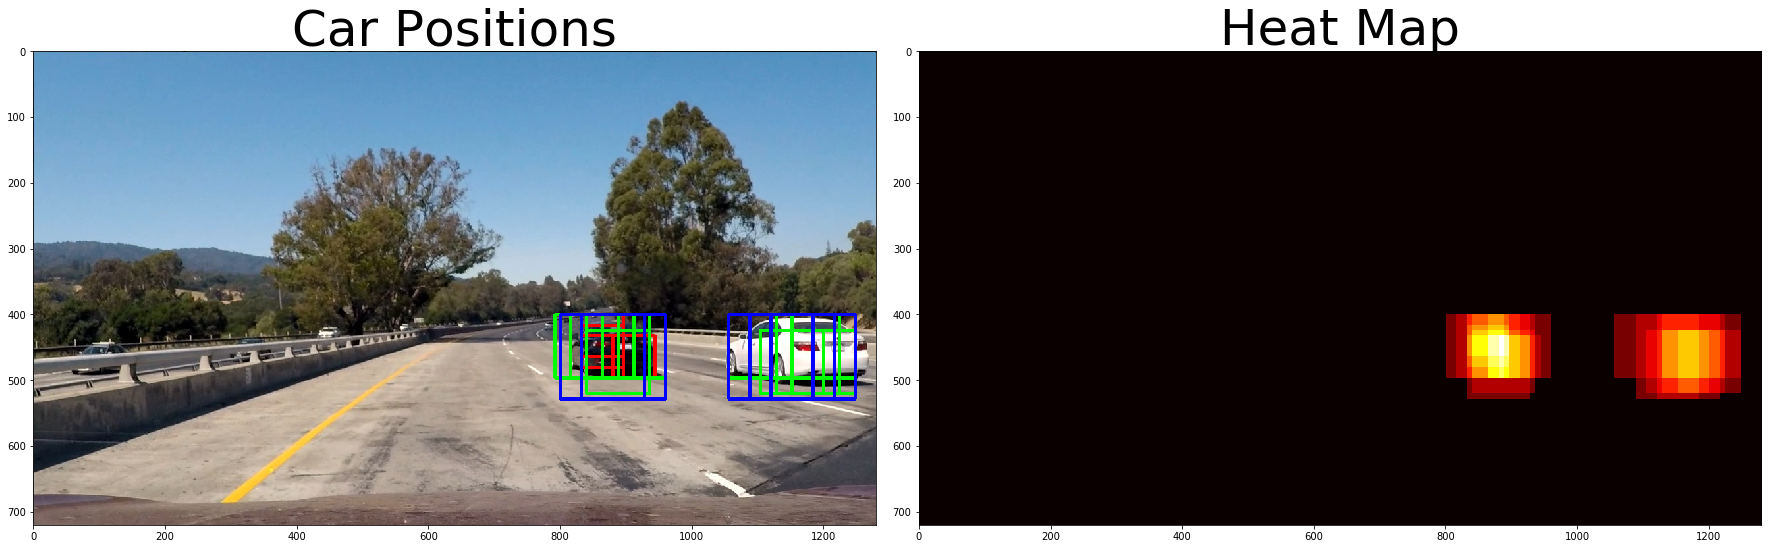

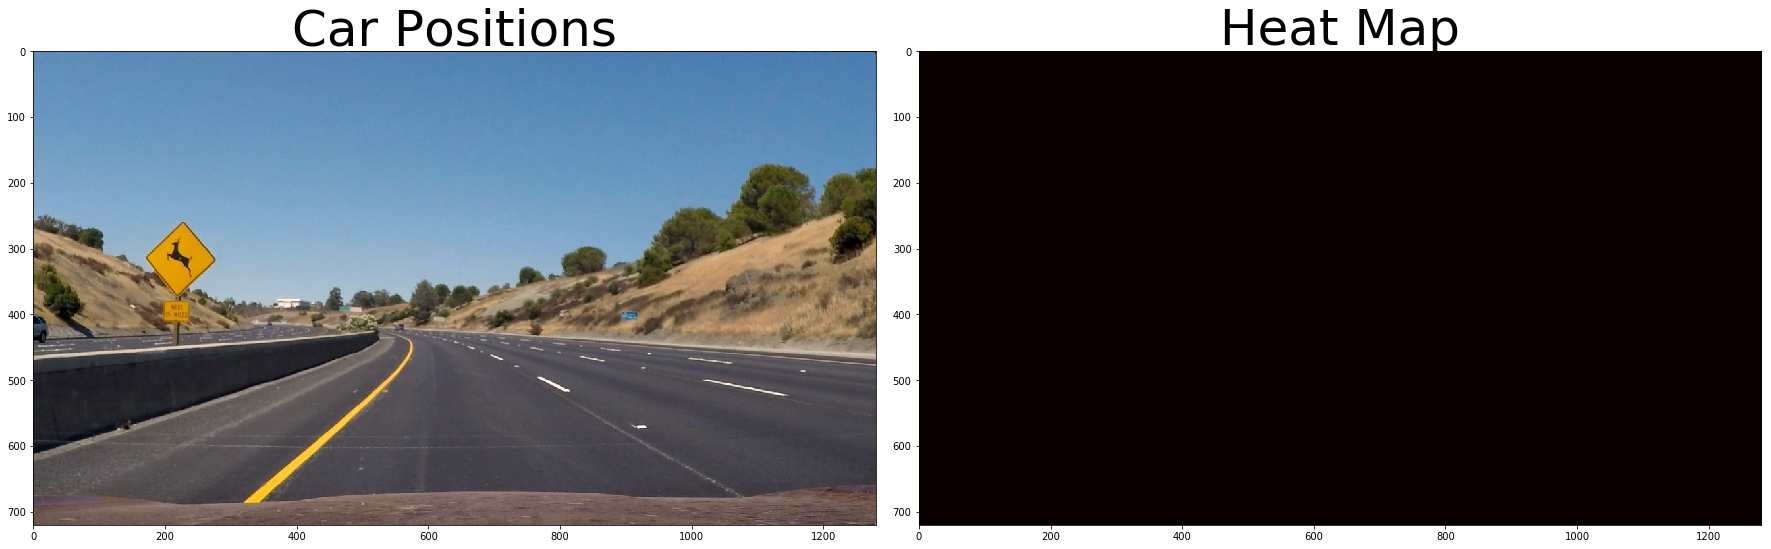

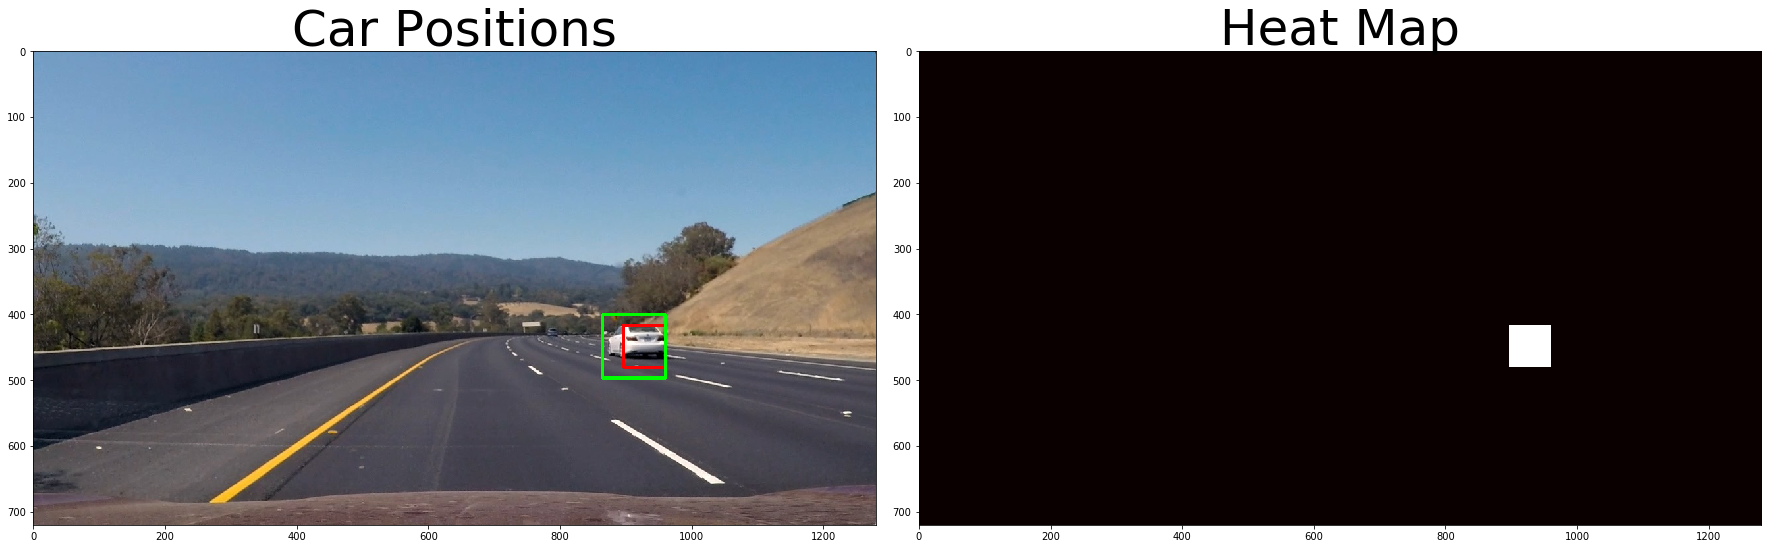

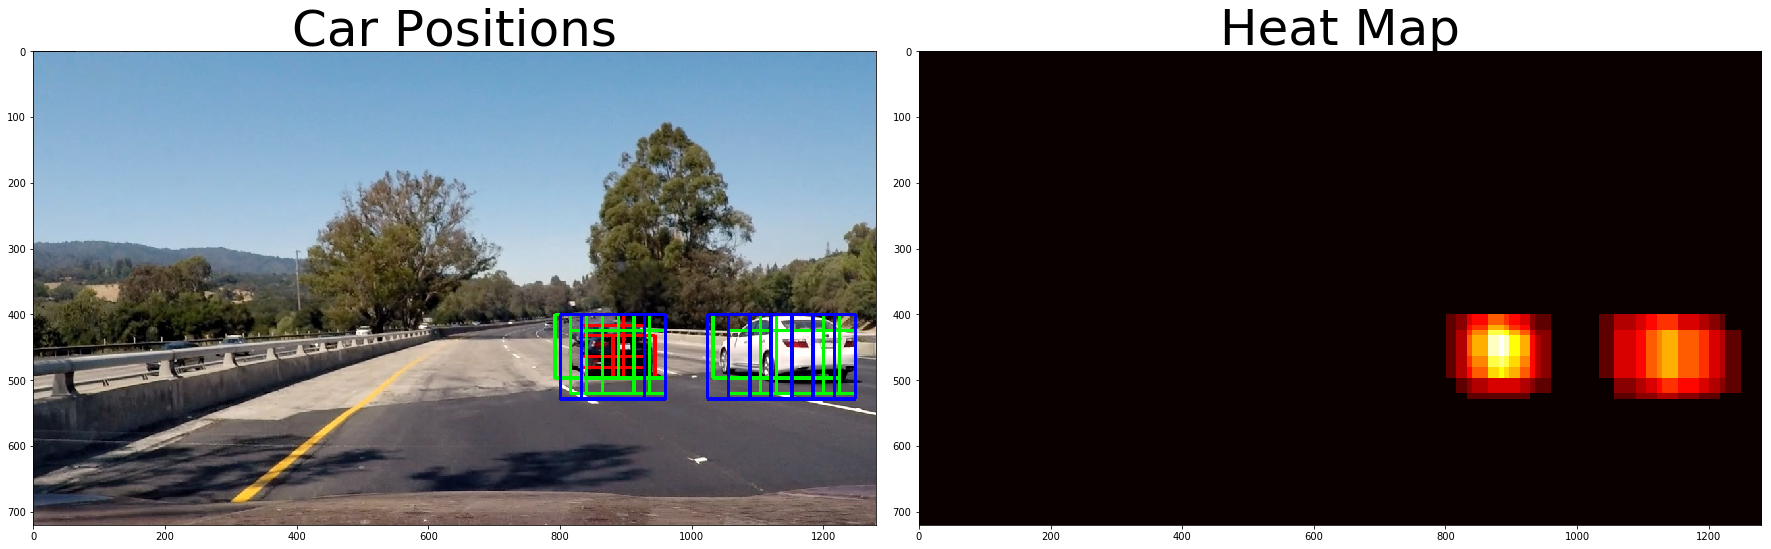

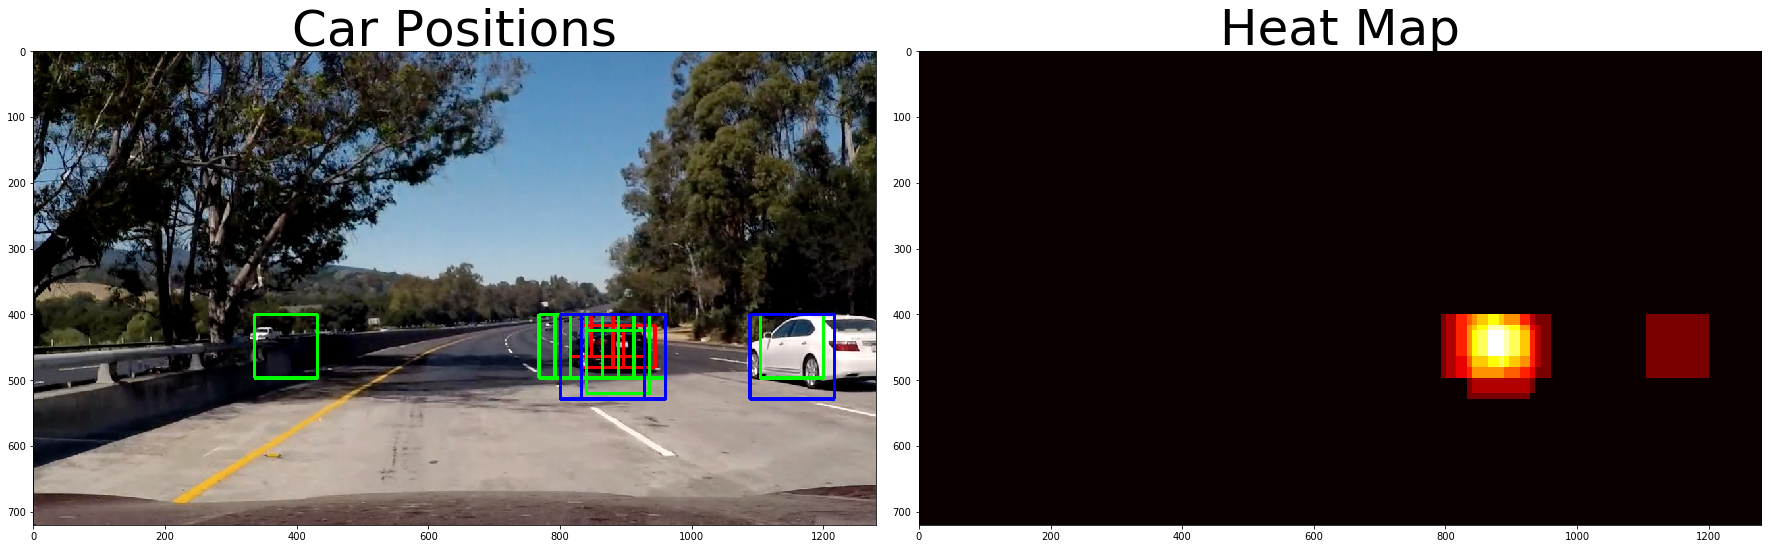

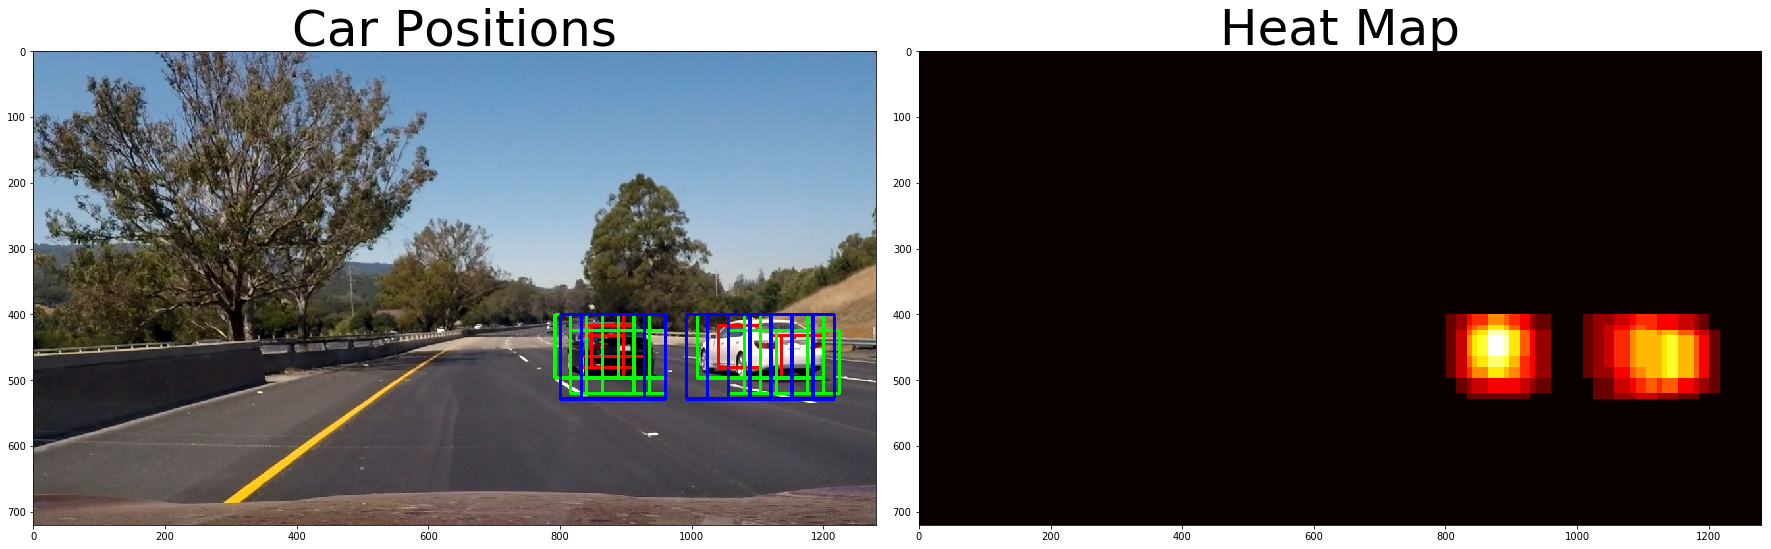

In [16]:
def multi_plot(img1, title1, img2, title2, video=False):
    if not video:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img1)
        ax1.set_title(title1, fontsize=50)
        ax2.imshow(img2, cmap='hot')
        ax2.set_title(title2, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return

tests = glob.glob('./test_images/test*.jpg')


for test in tests:
    img = mpimg.imread(test)
    img_out = np.copy(img)
    t1 = time.time()
    
    img_out, heatmap = pipeline(img, False, img_out)

    multi_plot(img_out,'Car Positions',heatmap,'Heat Map')
    print(time.time()-t1, 'seconds to process one image')


In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML 

video_output = 'project_video_output.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [44:31<00:02,  2.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 44min 31s


In [15]:
HTML("""
<video width="960" height="540"controls>
    <source src="{0}">
</video>
""".format(video_output))